In [36]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [37]:

def extra_parameters_from_label(label : str) -> dict:
    """Extract extra parameters from the label string."""
    params = {}
    cpus_per_node = 288 # Cirrus has 288 CPUs per node
    
    parts = label.split('_')
    for part in parts:
        if part.startswith('nodes'):
            params['nodes'] = int(part.replace('nodes', ''))
        elif part.startswith('ppn'):
            ppn = int(part.replace('ppn', ''))
            params['threads'] = cpus_per_node // ppn
        elif part.startswith('meshC'):
            params['mesh_C'] = int(part.replace('meshC', ''))
    return params


def parse_timer_file(filename : str) -> pd.DataFrame:
    """Parse the timer.txt file and return a DataFrame with timing data per subroutine."""

    data = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        pattern = r'\|\|\s*(.+?)\|\|\s*(\d+\.\d+)\|\|\s*(\d+\.\d+)\|\|\s*(\d+\.\d+)\|\|\s*(\d+)\|\|\s*(\d+\.\d+)\|\|\s*(\d+\.\d+)\|\|'
        for line in lines:
            match = re.match(pattern, line)
            if match:
                data.append({
                    'Subroutine': match.group(1),
                    'min_time': float(match.group(2)),
                    'avg_time': float(match.group(3)),
                    'max_time': float(match.group(4)),
                    'num_calls': int(match.group(5)),
                    'pct_total_time': float(match.group(6)),
                    'time_per_call': float(match.group(7))
                })
    df = pd.DataFrame(data)
    return df

In [5]:
root_dir = "/work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/results/threaded28Nov2025"


def get_timing_data(folder) -> pd.DataFrame:
    """Get timing data from the specified folder and add extra parameters from the folder name."""
    # Get the last directory in the path using os.path
    label = os.path.split(folder)[-1]
    data= parse_timer_file(filename = f"{folder}/timer.txt"
)
    parameters = extra_parameters_from_label(label)
    # Add each parameter as a new column
    for key, value in parameters.items():
        data[key] = value
    return data


# Get all subdirectories in the root_dir
subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Concatenate timing data from all subdirectories
data_frames = []
for subdir in subdirs:
    data_frames.append(get_timing_data(subdir))
all_data = pd.concat(data_frames, ignore_index=True)


In [39]:
def prepare_thread_scaling_data(all_data: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for thread scaling analysis. 
    Collect the maximum time for the semi_implicit_timestep_alg subroutine and substract the time for the first time step.
    """
    
    thread_scaling= all_data [ all_data["Subroutine"] == "semi_implicit_timestep_alg" ][["max_time","threads"]].reset_index( drop=True)
    first_step_scaling = all_data [ all_data["Subroutine"] == "first_step" ][["max_time","threads"]].reset_index( drop=True)
    thread_scaling["max_time"]-= first_step_scaling["max_time"]
    thread_scaling["max_time"]/=99 # Divide by the number of time steps minus one ( the first step is excluded)
    thread_scaling.sort_values("threads", inplace=True)
    thread_scaling.reset_index( drop=True, inplace=True)
    return thread_scaling



def plot_thread_scaling(thread_scaling_data: pd.DataFrame):
    """Plot thread scaling data."""
    
    plt.plot(thread_scaling_data["threads"], thread_scaling_data["max_time"], 'o--')
    plt.xlabel("Number of Threads per rank")
    plt.ylabel("Max Time (s)")
    sns.set_style("whitegrid")
    plt.show()

## Scaling with number of threads
On Cirrus-ex the optimal number of threads seem to be number one. While increasing the number of threads decreases the memory requirements, the time to solution per time-stemp decreases as you increase the number of threads.

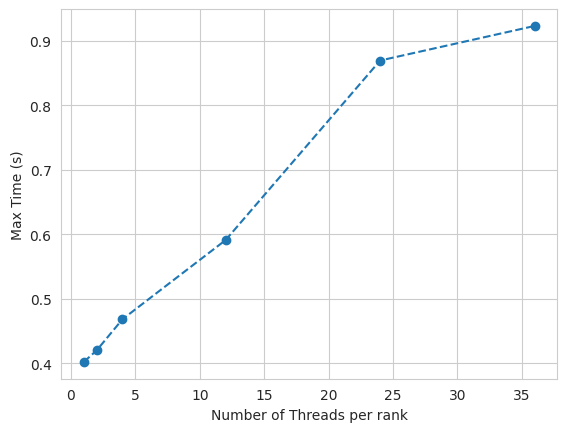

In [8]:
thread_scaling_data = prepare_thread_scaling_data(all_data)
thread_scaling_data.to_csv("thread_scaling_data.txt", sep=" ", index=False)
plot_thread_scaling(thread_scaling_data)

Cray-pat profiles were collecte for mpi traces (`-g mpi`) , omp traces (`-g omp`) and sampled profiles .
Data was extracted from craypat profiles using:

- `pat_report -T -s pe=ALL  -O ca` : Callect call stack iformation for mpi traces. all mpi calls happen on the master threads.
- `pat_report -T -O load_imbalance_thread ` : on openmp traces
- `pat_report   -O ca ` : on sampling data
- `pat_report   -O ca -s pe=ALL ` : on sampling data, saved in `report_pe.txt` files

The times in the craypat profilers already exclude the first step.

In [ ]:
import tools
from tools.craypat import extract_mpi_callstack_data

run_dir="/work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs" # Directoring containing profiles for different runs

ppn_list = [288,72,24,12,8] # CPUs per node

summaries = []
for ppn in tqdm.tqdm(ppn_list): # Iterate over runs with different number of threads
    report = f"{run_dir}/nodes192_ppn{ppn}_meshC1536_cray_pat_mpi/report.txt"
    print(f"Processing report: {report}")
    # Parse the report
    profile = extract_mpi_callstack_data(report) # Extract data from text report generated with pat_report
    
    calls = ["USER","MPI_SYNC","MPI"]
    for call in calls:
        summary= profile[call].timing.aggregate({'time':['min','max','mean','std']})
        summary['threads']=288/ppn
        summary['call'] = call
        summaries.append(summary)

summary_profile = pd.concat(summaries)
summary_profile.head(10)

  0%|          | 0/5 [00:00<?, ?it/s]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn288_meshC1536_cray_pat_mpi/report.txt


 20%|██        | 1/5 [00:21<01:26, 21.64s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn72_meshC1536_cray_pat_mpi/report.txt


 40%|████      | 2/5 [00:23<00:29,  9.80s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn24_meshC1536_cray_pat_mpi/report.txt


 60%|██████    | 3/5 [00:25<00:12,  6.39s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn12_meshC1536_cray_pat_mpi/report.txt


 80%|████████  | 4/5 [00:26<00:04,  4.30s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn8_meshC1536_cray_pat_mpi/report.txt


100%|██████████| 5/5 [00:27<00:00,  5.55s/it]


,time,threads,call
min,39.088038,1.0,USER
max,44.868999,1.0,USER
mean,41.775227,1.0,USER
std,0.728550,1.0,USER
min,10.623708,1.0,MPI_SYNC
max,14.704896,1.0,MPI_SYNC
mean,13.470185,1.0,MPI_SYNC
std,0.625294,1.0,MPI_SYNC
min,8.204901,1.0,MPI
max,14.797755,1.0,MPI


In [ ]:
compact_summary_profile = summary_profile.reset_index().pivot(values=['time'],columns=['index'],index=["threads"]).reset_index()
compact_summary_profile.columns = ['_'.join(col).strip().replace('__', '') for col in compact_summary_profile.columns.values]
compact_summary_profile.to_csv("thread_scaling_mpi.txt", sep=" ", index=False)
compact_summary_profile.head(10)


,threads,time_min_USER,time_max_USER,time_mean_USER,time_std_USER,time_min_MPI_SYNC,time_max_MPI_SYNC,time_mean_MPI_SYNC,time_std_MPI_SYNC,time_min_MPI,time_max_MPI,time_mean_MPI,time_std_MPI
0,1.0,39.088038,44.868999,41.775227,0.728550,10.623708,14.704896,13.470185,0.625294,8.204901,14.797755,10.897461,0.845740
1,4.0,49.578587,55.474928,52.074880,0.984015,30.388083,36.724578,34.450712,0.844693,9.066917,12.722764,10.972851,0.457434
2,12.0,63.871138,79.356956,71.655278,2.025021,38.149899,52.028595,45.084581,1.852996,10.726951,17.204414,13.902156,0.776331
3,24.0,76.935363,109.946282,88.112816,3.947287,36.311756,61.557288,53.657455,3.214627,16.404291,27.550068,21.474746,1.803688
4,36.0,87.437031,116.151022,95.797503,3.681762,34.268434,59.112181,51.988996,3.294708,20.051927,31.331327,25.001355,1.634380


In [ ]:
plt.plot(compact_summary_profile["threads"], compact_summary_profile[("time", "max")], 'o--')